## Installation und Einrichtung
Bevor du startest, stelle sicher, dass du die folgenden Pakete installiert hast. Führe in einer Jupyter-Notebook-Zelle Folgendes aus:

``pip install stable-baselines3 pandas matplotlib``

stable-baselines3: Für Reinforcement Learning.
pandas: Für die Datenverarbeitung.
matplotlib: Für die grafische Darstellung.
ccxt: Für die API-Anbindung an Kryptobörsen wie Binance.

##  Datenimport und Vorbereitung
In dieser Zelle holen wir die historischen Bitcoin-Daten:

In [89]:
import pandas as pd
import yfinance as yf

def fetch_bitcoin_data(start_date, end_date):
    """
    Ruft Bitcoin-Daten von Yahoo Finance für den angegebenen Zeitraum ab.

    Args:
        start_date (str): Startdatum im Format 'YYYY-MM-DD'.
        end_date (str): Enddatum im Format 'YYYY-MM-DD'.

    Returns:
        pd.DataFrame: DataFrame mit den historischen Kursdaten.
    """
    try:
        # Überprüfung der Datumsformate
        pd.to_datetime(start_date)
        pd.to_datetime(end_date)

        # Sicherstellen, dass start_date vor end_date liegt
        if start_date >= end_date:
            raise ValueError("Das Startdatum muss vor dem Enddatum liegen.")

        # Lade Daten von Yahoo Finance
        df = yf.download("BTC-USD", start=start_date, end=end_date, interval="1d")

        # Überprüfen, ob Daten zurückgegeben wurden
        if df.empty:
            raise ValueError("Keine Daten für den angegebenen Zeitraum verfügbar.")

        # Umbenennen der Spalten für Konsistenz
        df.rename(columns={
            "Open": "open",
            "High": "high",
            "Low": "low",
            "Close": "close",
            "Volume": "volume"
        }, inplace=True)

        # Filtere die relevanten Spalten und setze den Zeitstempel als Index
        df = df[["open", "high", "low", "close", "volume"]]
        df.index.name = "timestamp"

        return df

    except Exception as e:
        print(f"Fehler beim Abrufen der Daten: {e}")
        return pd.DataFrame()

In [90]:
# Abrufen der Daten
data = fetch_bitcoin_data('2018-01-01', '2023-12-01')
print(data.head())  # Zeige die ersten Zeilen der Daten

[*********************100%***********************]  1 of 1 completed

Price               open          high           low         close  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
timestamp                                                            
2018-01-01  14112.200195  14112.200195  13154.700195  13657.200195   
2018-01-02  13625.000000  15444.599609  13163.599609  14982.099609   
2018-01-03  14978.200195  15572.799805  14844.500000  15201.000000   
2018-01-04  15270.700195  15739.700195  14522.200195  15599.200195   
2018-01-05  15477.200195  17705.199219  15202.799805  17429.500000   

Price            volume  
Ticker          BTC-USD  
timestamp                
2018-01-01  10291200000  
2018-01-02  16846600192  
2018-01-03  16871900160  
2018-01-04  21783199744  
2018-01-05  23840899072  


- **fetch_ohlcv**: Ruft Open, High, Low, Close, Volume (OHLCV) Daten ab.
- **timestamp**: Zeitstempel für jeden Tag.
- **close**: Schlusskurs, der für das Training verwendet wird

## Umgebung und Agent erstellen
Hier definieren wir die RL-Umgebung und den Agenten:

In [91]:
import gym
import numpy as np

class BitcoinPredictionEnv(gym.Env):
    def __init__(self, data, window_size=60, prediction_horizon=7):
        super(BitcoinPredictionEnv, self).__init__()
        self.data = data[['open', 'high', 'low', 'close', 'volume']].values
        self.window_size = window_size
        self.prediction_horizon = prediction_horizon
        self.current_step = window_size

        # Action Space: Vorhersage für die nächsten `prediction_horizon` Tage (relative Preisänderungen)
        self.action_space = gym.spaces.Box(
            low=-1, high=1, shape=(prediction_horizon,), dtype=np.float32
        )

        # Observation Space: Fenstergröße x Anzahl der Features
        n_features = self.data.shape[1]
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(window_size, n_features), dtype=np.float32
        )

    def reset(self):
        self.current_step = self.window_size
        return self._get_observation()

    def _get_observation(self):
        """
        Gibt die letzten `window_size` Tage als normalisierte Beobachtung zurück.
        """
        window = self.data[self.current_step - self.window_size:self.current_step]
        normalized_window = (window - np.min(self.data, axis=0)) / (
            np.max(self.data, axis=0) - np.min(self.data, axis=0)
        )
        return normalized_window

    def step(self, action):
        """
        Führt die Vorhersage aus und berechnet die Belohnung.
        """
        # Abbruchbedingung
        if self.current_step + self.prediction_horizon >= len(self.data):
            done = True
            return self._get_observation(), 0, done, {}

        # Tatsächliche Kursentwicklung für die nächsten `prediction_horizon - 1` Tage
        actual_prices = self.data[self.current_step:self.current_step + self.prediction_horizon, 3]  # Schlusskurse
        actual_changes = (actual_prices - actual_prices[0]) / actual_prices[0]  # 7 Werte

        # Berechnung der Belohnung (z. B. MSE zwischen vorhergesagten und tatsächlichen Änderungen)
        reward = -np.mean((actual_changes - action) ** 2)   # Negative MSE

        # Schritt vorwärts
        self.current_step += 1
        done = self.current_step + self.prediction_horizon >= len(self.data)

        return self._get_observation(), reward, done, {}


In [92]:
def add_technical_indicators(data):
    """
    Fügt technische Indikatoren wie gleitende Durchschnitte dem DataFrame hinzu.

    Args:
        data (pd.DataFrame): Historische Kursdaten.

    Returns:
        pd.DataFrame: DataFrame mit zusätzlichen Indikatoren.
    """
    data['sma_10'] = data['close'].rolling(window=10).mean()
    data['sma_30'] = data['close'].rolling(window=30).mean()
    data['ema_10'] = data['close'].ewm(span=10, adjust=False).mean()
    data['ema_30'] = data['close'].ewm(span=30, adjust=False).mean()
    
    # Entferne NaN-Werte, die durch gleitende Fenster entstehen
    data = data.dropna()
    return data


## Training und Modell speichern
Führe diesen Code aus, um das Modell zu trainieren und zu speichern:

In [93]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Daten vorbereiten
data = fetch_bitcoin_data('2018-01-01', '2023-12-31')
data = add_technical_indicators(data)
if data.empty:
    raise ValueError("Die geladenen Daten sind leer. Überprüfen Sie den Zeitraum oder die API.")

# Umgebung initialisieren
env = DummyVecEnv([lambda: BitcoinPredictionEnv(data, window_size=60, prediction_horizon=7)])

# Versuch, ein bestehendes Modell zu laden
model_path = "bitcoin_prediction_model.zip"
try:
    model = PPO.load(model_path, env=env)  # Versuche, bestehendes Modell zu laden
    print("Modell erfolgreich geladen. Training wird fortgesetzt.")
except (FileNotFoundError, ValueError) as e:
    print(f"Kein bestehendes Modell gefunden oder Fehler beim Laden: {e}")
    # Neues Modell erstellen, falls keins existiert
    model = PPO('MlpPolicy', env, verbose=1, tensorboard_log="./bitcoin_prediction_logs/")
    print("Neues Modell wurde erstellt.")

# Modell trainieren
total_timesteps = 100000
model.learn(total_timesteps=total_timesteps, reset_num_timesteps=False)
print(f"Modell wurde für {total_timesteps} Schritte trainiert.")

# Modell speichern
model.save(model_path)
print(f"Modell wurde unter '{model_path}' gespeichert.")


[*********************100%***********************]  1 of 1 completed

Modell erfolgreich geladen. Training wird fortgesetzt.
Logging to ./bitcoin_prediction_logs/PPO_0



c:\Users\tlfin\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-------------------------------
| time/              |        |
|    fps             | 1392   |
|    iterations      | 1      |
|    time_elapsed    | 1      |
|    total_timesteps | 303104 |
-------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 955           |
|    iterations           | 2             |
|    time_elapsed         | 4             |
|    total_timesteps      | 305152        |
| train/                  |               |
|    approx_kl            | 0.031949148   |
|    clip_fraction        | 0.341         |
|    clip_range           | 0.2           |
|    entropy_loss         | 9.25          |
|    explained_variance   | 0.00045472383 |
|    learning_rate        | 0.0003        |
|    loss                 | -0.0495       |
|    n_updates            | 1480          |
|    policy_gradient_loss | -0.00484      |
|    std                  | 0.0644        |
|    value_loss           | 

## Evaluierung

In [94]:
def evaluate_prediction_model(model, env, n_eval_episodes=10):
    rewards = []
    for _ in range(n_eval_episodes):
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, info = env.step(action)
            total_reward += reward
        rewards.append(total_reward)
    mean_reward = np.mean(rewards)
    std_reward = np.std(rewards)
    return mean_reward, std_reward

mean_reward, std_reward = evaluate_prediction_model(model, env)
print(f"Durchschnittliche Belohnung: {mean_reward}, Standardabweichung: {std_reward}")


Durchschnittliche Belohnung: -11.03166389465332, Standardabweichung: 0.0


## Vorhersage

In [ ]:
# Testdaten abrufen
test_data = fetch_bitcoin_data('2024-05-01', '2024-10-07')  # Früh starten wegen SMA
test_data = add_technical_indicators(test_data)

# Sicherstellen, dass genügend Daten vorhanden sind
if len(test_data) < 60 + 7:  # Mindestens 60 für das Fenster und 7 für den Vergleich
    raise ValueError("Nicht genügend Testdaten vorhanden.")

# Letztes Eingabefenster: Genau 60 Tage vor dem Vorhersagezeitraum
test_window = test_data['2024-08-02':'2024-09-30'][['open', 'high', 'low', 'close', 'volume']].values
print("Shape des Eingabefensters:", test_window.shape)  # Erwartet: (60, 5)

# Normalisieren
min_vals = np.min(test_data[['open', 'high', 'low', 'close', 'volume']].values, axis=0)
max_vals = np.max(test_data[['open', 'high', 'low', 'close', 'volume']].values, axis=0)
normalized_test_window = (test_window - min_vals) / (max_vals - min_vals)

# Vorhersage für den Zeitraum 01.05. bis 07.05.
obs = normalized_test_window
predicted_changes, _ = model.predict(obs, deterministic=True)

# Startwert (Schlusskurs am 30.04.)
last_close_price = test_data['close'].loc['2024-09-30']

# Vorhergesagte Schlusskurse berechnen
predicted_prices = [last_close_price * (1 + predicted_changes[0])]
for change in predicted_changes[1:]:
    predicted_prices.append(predicted_prices[-1] * (1 + change))

# Sicherstellen, dass `predicted_prices` eine Liste ist
predicted_prices = list(predicted_prices)

# Vorhersagezeiträume definieren
prediction_dates = pd.date_range('2024-10-01', periods=7)

# Ergebnisse ausgeben
print("Vorhergesagte Schlusskurse für den Zeitraum 01.10.2024 bis 07.10.2024:")
for date, price in zip(prediction_dates, predicted_prices):
    print(f"{date.strftime('%Y-%m-%d')}: {float(price):.2f}")

[*********************100%***********************]  1 of 1 completed

Shape des Eingabefensters: (124, 5)


ValueError: Error: Unexpected observation shape (124, 5) for Box environment, please use (60, 5) or (n_env, 60, 5) for the observation shape.

## Darstellen

Actual prices shape: (7, 1)
Predicted prices shape: (7,)
Lower bound shape: (7,)
Upper bound shape: (7,)
Dates length: 7


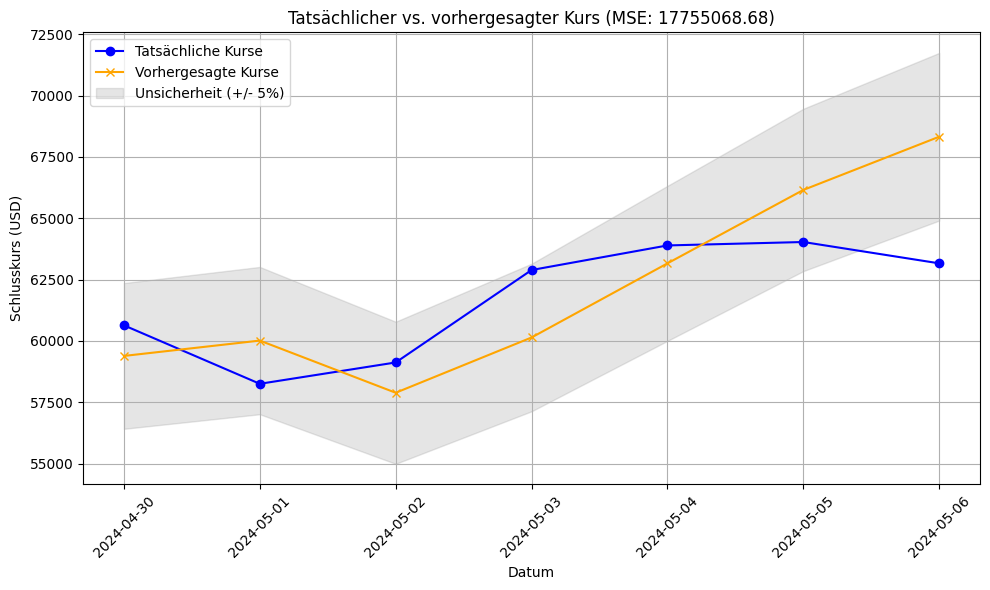

In [96]:
import matplotlib.pyplot as plt
import numpy as np

# Tatsächliche Schlusskurse
actual_prices = test_data['close'].iloc[-7:].values

# Vorhergesagte Schlusskurse
predicted_prices = np.array(predicted_prices).flatten()  # Sicherstellen, dass es ein 1D-Array ist

# Fehlerbänder
lower_bound = predicted_prices * 0.95
upper_bound = predicted_prices * 1.05

# Überprüfen der Dimensionen
print("Actual prices shape:", np.shape(actual_prices))
print("Predicted prices shape:", np.shape(predicted_prices))
print("Lower bound shape:", np.shape(lower_bound))
print("Upper bound shape:", np.shape(upper_bound))

# MSE berechnen
mse = np.mean((actual_prices - predicted_prices) ** 2)

# Zeitachse
dates = test_data.index[-7:]
print("Dates length:", len(dates))

# Plot erstellen
plt.figure(figsize=(10, 6))

# Tatsächliche Kurse plotten
plt.plot(dates, actual_prices, label='Tatsächliche Kurse', marker='o', color='blue')

# Vorhergesagte Kurse plotten
plt.plot(dates, predicted_prices, label='Vorhergesagte Kurse', marker='x', color='orange')

# Fehlerbänder hinzufügen
plt.fill_between(dates, lower_bound, upper_bound, color='gray', alpha=0.2, label='Unsicherheit (+/- 5%)')

# Diagrammanpassungen
plt.xlabel('Datum')
plt.ylabel('Schlusskurs (USD)')
plt.title(f'Tatsächlicher vs. vorhergesagter Kurs (MSE: {mse:.2f})')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Plot anzeigen
plt.show()
